In [ ]:
# os.chdir('..')
# !rm -rf ./EasyReadNews
import os
!git clone 'https://github.com/lazyYC/EasyReadNews.git'
os.chdir('./EasyReadNews')

fatal: destination path 'EasyReadNews' already exists and is not an empty directory.


In [ ]:
!pip install -q transformers  rouge-score
!pip3 install newspaper3k
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from newspaper import fulltext
import requests, sys, random, re, logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils
import matplotlib.pyplot as plt
import sentencepiece as spm
from config import *
from fairseq.tasks.translation import TranslationConfig, TranslationTask


fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp37-cp37m-linux_x86_64.whl size=2863605 sha256=a0873d7df45117b170e45c64b3471979e901fddbfae417c58acbf341c1f55782
  Stored in directory: /tmp/pip-ephem-wheel-cache-uymkl79o/wheels/09/c7/2c/29d5d4d475c5432b678

### 載入transformers, rouge-score, newspaper套件
* 輸入網址透過 newspaper 抓取新聞內容
* 交由 pre-trained model產生summerization
* 產出 txt 檔交由後續 translation model 使用

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

url = input("Please paste the url of the news to be summarized.")
text = fulltext(requests.get(url).text)
ARTICLE_TO_SUMMARIZE = text
inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

# Generate Summary
summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=100, early_stopping=True)
output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
str2 = output.split('.')

with open("summary_out_put.txt","w+") as f:
  for i in range(len(str2)):
    f.write(str2[i])
    if i != len(str2) - 1:
      f.write('\n')
with open("summary_out_put.txt", "r") as f:
  data = f.readlines()
  for i in data:
    print(i)

Please paste the url of the news to be summarized.https://edition.cnn.com/2021/12/21/politics/republican-midterm-candidates-2020-election-lies/index.html


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 Republicans trying to win party nominations in 2022 have refused to publicly admit that Trump just plain lost 

 Some candidates are aggressive, turning the lie that Trump was the rightful winner into a central part of their campaign pitches 

 Polls show that a large majority of Republicans will not concede that American voters actually chose Biden over Trump 



In [ ]:
## set device
## 如果GPU不能用，就把前兩行markdown
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

##logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

## seed
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath, map_location=torch.device('cpu'))
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

from NoamOpt import *

## set args
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

2022-01-10 15:17:12 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

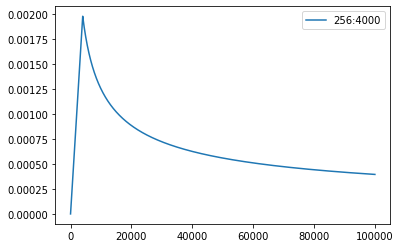

In [ ]:
from classSeq2Seq import *
model = build_model(arch_args, task)
logger.info(model)

optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])

try_load_checkpoint(model, optimizer, name=config.resume)

In [ ]:
torch.load('./checkpoints/transformer/checkpoint8.pt', map_location=torch.device('cpu'))
model.to(device)

Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (final_layer_norm): LayerNo

In [ ]:
## 刪掉上次predict可能殘存的test檔
to_del_raw = ['test.en', 'test.raw.en', 'test.raw.clean.en']
for f in to_del_raw:
  if Path(f'./DATA/rawdata/ted2020/{f}').exists():
    !rm ./DATA/rawdata/ted2020/{f}
    print(f'{f} is deleted now.')
  else:
    print(f'{f} does not exists.')
    
## 這邊上傳要預測的文字檔（summarized）
!cp './summary_out_put.txt' './DATA/rawdata/ted2020/test.raw.en' 

test.en does not exists.
test.raw.en is deleted now.
test.raw.clean.en does not exists.


In [ ]:
!cp './summary_out_put.txt' './DATA/rawdata/ted2020/test.raw.en' 

In [ ]:
# 把test.zh改成跟test.en一樣多行
with open('./DATA/rawdata/ted2020/test.raw.en', 'r') as en:
  length = len(en.readlines())
  tmp = open('./DATA/rawdata/ted2020/test.zh', 'r')
  repeat = tmp.readline()
  tmp.close()
  with open('./DATA/rawdata/ted2020/test.zh', 'w') as zh:
    for i in range(length):
      zh.write(repeat)    

### 

In [ ]:
# example 固定是4000行，要把新聞捕到剛好4000行，不然沒辦法跑

# with open('./DATA/rawdata/ted2020/test.raw.en', 'r') as f:
#   length = len(f.readlines())
#   print(length)

# with open('./DATA/rawdata/ted2020/test.raw.en', 'r+') as f:
#     f.readlines()
#     while True:
#         f.seek(0)
#         if len(f.readlines()) == 4000:
#             break
#         else:
#             f.write('\n')

# with open('./DATA/rawdata/ted2020/test.raw.en', 'r') as f:
#   length = len(f.readlines())
#   print(length)

3
4000


In [ ]:
from cleanse import *
clean_corpus('./DATA/rawdata/ted2020/test.raw', 'en', 'zh', ratio=-1, min_len=-1, max_len=-1)
spm_model = spm.SentencePieceProcessor(model_file=str('./DATA/rawdata/ted2020/spm8000.model'))

# input的資料
if Path('./DATA/rawdata/ted2020/test.en').exists():
  print('資料已經轉成subwords，跳過此步驟')
else:
  with open('./DATA/rawdata/ted2020/test.en', 'w+') as out_f:
    with open('./DATA/rawdata/ted2020/test.raw.clean.en' ,'r') as f:
      for line in f:
        line = line.strip()
        tok = spm_model.encode(line, out_type=str)
        print(' '.join(tok), file=out_f)
# !head {'./DATA/rawdata/ted2020/test.en'} -n 10

## 把上次binarize的bin清除
p = './DATA/data-bin/ted2020/'
ToDelEveryPred = ['test.en-zh.en.bin', 'test.en-zh.en.idx', 'test.en-zh.zh.bin', 'test.en-zh.zh.idx']
for f in ToDelEveryPred:
  if Path(p + f).exists():
    !rm {p}{f}
    print(f'{f} is deleted now')

## binarize
binpath = Path('./DATA/data-bin', 'ted2020')
!python -m fairseq_cli.preprocess \
    --source-lang 'en'\
    --target-lang 'zh'\
    --testpref './DATA/rawdata/ted2020/test'\
    --destdir {binpath}\
    --srcdict './DATA/data-bin/ted2020/dict.en.txt' \
    --tgtdict './DATA/data-bin/ted2020/dict.zh.txt' \
    --workers 2

#################################################################

sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs


def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    print(hyps)
    with open(outfile, "w") as f:
            for i in hyps:
              f.write(i+"\n")

test.en-zh.en.bin is deleted now
test.en-zh.en.idx is deleted now
test.en-zh.zh.bin is deleted now
test.en-zh.zh.idx is deleted now
2022-01-10 15:23:02 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, ta

In [ ]:
generate_prediction(model, task)
p = './DATA/data-bin/ted2020/'
ToDelEveryPred = ['test.en-zh.en.bin', 'test.en-zh.en.idx', 'test.en-zh.zh.bin', 'test.en-zh.zh.idx']
for f in ToDelEveryPred:
  if Path(p + f).exists():
    !rm {p}{f}
    print(f'{f} is deleted now')

2022-01-10 15:23:11 | INFO | fairseq.data.data_utils | loaded 3 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-01-10 15:23:11 | INFO | fairseq.data.data_utils | loaded 3 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-01-10 15:23:11 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 3 examples


prediction:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


['2022年 , 共和黨試圖贏得黨派的諾議 , 公眾拒絕川普消失的公眾承諾 , 只是平原本消失了 。', '有些候選人被侵略 , 轉變川普是正確的贏家 , 進入他們的活動的中心 。', '投票顯示 , 大部分的共和黨人並不認為美國選民其實是在川普中挑選的總統 。']
test.en-zh.en.bin is deleted now
test.en-zh.en.idx is deleted now
test.en-zh.zh.bin is deleted now
test.en-zh.zh.idx is deleted now
